## Loading Data

In [1]:
import os
import ast
import typing
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import date, datetime
import matplotlib as plt

pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
months = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [4]:
if not os.path.isdir("data"):
    os.makedirs("data")

if not len(os.listdir('./data')):
    i2m = list(zip(range(1,13), months))
    os.chdir("data")
    for year in [2023, 2022, 2021, 2020, 2019]:
        for month, month_name in i2m:        
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
    os.chdir("..")

In [5]:
df = pd.DataFrame()

In [6]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(
        df['last_reported'].apply(lambda x: get_datetime(x))
    )
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    
    return df

In [7]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [8]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['station_id', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    # Create percentage of docks availability
    #Maria: this is incorrect
    new_df['percentage_docks_available'] = new_df['num_bikes_available'] / (new_df['num_docks_available'] + new_df['num_bikes_available'])

    return new_df

In [9]:
for csv in tqdm(os.listdir('./data')):
    new_df = pd.read_csv('./data/' + csv)
    new_df = process_new_df(new_df)
    
    # Filter out incorrect dates
    year, month, *_ = csv.split('_')
    year, month = int(year), int(month)
    new_df = new_df[(new_df.year == year) & (new_df.month == month)]
    
    df = pd.concat(
        [df, new_df], 
        axis=0
    )

100%|███████████████████████████████████████████| 51/51 [25:20<00:00, 29.82s/it]


In [10]:
# Handle NaN: Assume that the NaN in traffic is 0
df.traffic = df.traffic.replace(np.nan, 0)

In [11]:
df.shape

(16723475, 21)

In [13]:
df['year'].value_counts()

2022    4423951
2021    4405069
2020    3576052
2019    2624539
2023    1693864
Name: year, dtype: int64

In [14]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,date_time,date,percentage_docks_available
1,1,2023,1,1,0,37.500000,34.916667,2.583333,8.416667,1.672529e+09,1.0,1.0,1.0,1.0,1.0,0.0,1.672530e+09,11.750000,2023-01-01 00:00:00,2023-01-01,0.816697
2,1,2023,1,1,1,39.333333,36.666667,2.666667,6.666667,1.672533e+09,1.0,1.0,1.0,1.0,1.0,0.0,1.672533e+09,10.416667,2023-01-01 01:00:00,2023-01-01,0.855072
3,1,2023,1,1,2,38.666667,37.416667,1.250000,7.250000,1.672537e+09,1.0,1.0,1.0,1.0,1.0,0.0,1.672537e+09,14.000000,2023-01-01 02:00:00,2023-01-01,0.842105
4,1,2023,1,1,3,39.583333,37.833333,1.750000,6.250000,1.672540e+09,1.0,1.0,1.0,1.0,1.0,0.0,1.672540e+09,11.833333,2023-01-01 03:00:00,2023-01-01,0.863636
5,1,2023,1,1,4,39.333333,38.250000,1.083333,6.583333,1.672544e+09,1.0,1.0,1.0,1.0,1.0,0.0,1.672544e+09,11.500000,2023-01-01 04:00:00,2023-01-01,0.856624


### Add station information

In [14]:
def get_station_json(
    url: str = 'https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download'
):
    
    res = requests.get(url)
    return res.json()
station_json = get_station_json()

In [15]:
station_df = pd.DataFrame(station_json['data']['stations'])
station_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,nearby_distance,_ride_code_support,rental_uris,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",08013,46,True,1000.0,True,None,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",08013,29,True,1000.0,True,None,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",08013,27,True,1000.0,True,None,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",08013,21,True,1000.0,True,None,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",08018,39,True,1000.0,True,None,NaN


In [16]:
# Some fields are not going to be used
station_drop_fields = [
    'physical_configuration',          # unique value: ELECTRICBIKESTATION
    '_ride_code_support',              # unique value: all True
    'nearby_distance',                 # unique value: 1000
    'name', 'address', 'post_code',    # too specific to each of the stations
    'is_charging_station',             # already in the main df
    'rental_uris', 'cross_street',     # vast majority are none
    
]

In [17]:
station_df = station_df.drop(station_drop_fields, axis=1)


In [18]:
station_df['station_id'].value_counts().sort_values()

1      1
5      1
6      1
7      1
8      1
      ..
518    1
505    1
393    1
507    1
519    1
Name: station_id, Length: 509, dtype: int64

In [19]:
df['station_id'].value_counts().sort_values()

530        3
529       22
532       47
520      433
431     7284
       ...  
367    34897
67     34897
347    34899
213    34900
389    35054
Name: station_id, Length: 516, dtype: int64

In [20]:
df.shape

(16723475, 21)

### Merging main df with station information. Be careful: the total number of station_id is not the same in both data sets

In [25]:
#Take any characteristic of the dataset that is going to be merge to the main one
print(station_df['capacity'].isna().sum())
df_copy = df.copy()
df_merge = pd.merge(df_copy, station_df, on='station_id', how='left')
#Check the same characteristic as previously
print(df_merge['capacity'].isna().sum())
print(df_merge['capacity'].isnull().sum())

0
55453
55453


In [26]:
print(station_df.shape)
print(df_copy.shape)
print(df_merge.shape)

(509, 5)
(16723475, 21)
(16723475, 25)


In [28]:
#Do not drop rows

df_merge['capacity'] = df_merge['capacity'].fillna(0)
df_merge = df_merge.drop(df_merge[df_merge['capacity'] == 0].index)
print(df_merge.shape)

(16668022, 25)


### Add Weather information

Add information relative to the wather ([source](https://www.visualcrossing.com/weather/weather-data-services#))


In [29]:
print('Start date: ', df['date'].min())
print('End date: ', df['date'].max())

Start date:  2019-03-28
End date:  2023-05-31


In [30]:
def weather_api_extraction(url: str) -> pd.DataFrame:
    response = requests.get(url)
    response_json = response.json()
    
    weather_df = pd.json_normalize(response_json['days'])
    
    return weather_df

In [31]:
def weather_df_drop_columns(
    weather_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'datetimeEpoch', 
        'tzoffset', 
        'source',
        'name',                     # all barcelona
        'stations',                 # which stations tracked that weather
        'severerisk'                # all nulls
        'precipprob',               # 100 if it rains, 0 otherwise. Doesn't add new info
        'preciptype',               # 'rain' if it rains, 'snow' if it snows. Doesn't add new info
        'sunrise', 'sunset',        # simplify variables, too specific
        'description',              # simplify variables, too specific
        'sunrise',                  # simplify variables, too specific
        'sunset',                   # simplify variables, too specific
        'moonphase',                # simplify variables, too specific
        'sealevelpressure',         # simplify variables, too specific
    ]
):
    
    return weather_df.drop(columns_to_drop, axis=1, errors='ignore')

In [32]:
def process_weather_df(weather_df: pd.DataFrame) -> pd.DataFrame:
    weather_df.datetime = pd.to_datetime(weather_df.datetime)
    weather_df['date'] = weather_df.datetime.dt.date
    
    return weather_df

In [33]:
os.makedirs('./weather', exist_ok=True)

if not len(os.listdir('./weather')):
    weather_url1 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2019-03-28/2021-11-30?unitGroup=metric&include=days&key=4T9KXABWNUV92K2WTZMA7JXZ3&contentType=json'
    weather_df1 = weather_api_extraction(weather_url1)
    weather_df1.to_csv('./weather/weather_2019_03_28_to_2021_11_30.csv', index=False, header=True)
    
    weather_url2 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2021-12-01/2023-04-30?unitGroup=metric&include=days&key=6NT6N8CRPMNTAEE2FH2EQZ98U&contentType=json'
    weather_df2 = weather_api_extraction(weather_url2)
    weather_df2.to_csv('./weather/weather_2021_12_01_to_2023_04_30.csv', index=False, header=True)

else:
    weather_df1 = pd.read_csv('./weather/weather_2019_03_28_to_2021_11_30.csv')
    weather_df2 = pd.read_csv('./weather/weather_2021_12_01_to_2023_04_30.csv')   

In [34]:
weather_df = pd\
    .concat([weather_df1, weather_df2], axis=0)\
    .reset_index(drop=True)

In [35]:
weather_df = weather_df_drop_columns(weather_df)
weather_df = process_weather_df(weather_df)

In [36]:
weather_df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,date
0,2019-03-28,16.8,6.4,12.1,16.8,3.7,11.5,4.4,60.6,0.0,0.0,0.0,0.0,0.0,21.5,17.3,42.8,1027.6,1.1,16.1,221.4,19.2,7.0,1553751710,1553796707,Clear,clear-day,NaN,2019-03-28
1,2019-03-29,16.3,8.8,12.8,16.3,6.7,12.6,5.1,60.6,0.0,0.0,0.0,0.0,0.0,24.8,19.8,76.9,1027.2,8.9,16.1,222.3,19.1,7.0,1553838009,1553883172,Clear,clear-day,NaN,2019-03-29
2,2019-03-30,16.0,6.4,12.0,16.0,4.2,11.6,5.8,66.0,0.0,0.0,0.0,0.0,0.0,24.3,19.1,79.9,1023.8,29.4,15.5,224.5,19.6,7.0,1553924308,1553969637,Partially cloudy,partly-cloudy-day,NaN,2019-03-30
3,2019-03-31,15.9,8.4,12.5,15.9,6.9,12.4,7.9,73.5,0.0,0.0,0.0,0.0,0.0,37.6,31.2,71.2,1017.5,50.3,14.7,154.2,12.8,6.0,1554010607,1554056102,Partially cloudy,partly-cloudy-day,NaN,2019-03-31
4,2019-04-01,17.3,9.8,13.8,17.3,9.0,13.7,6.1,60.7,0.0,0.0,0.0,0.0,0.0,23.4,18.1,126.5,1015.2,35.0,15.3,214.7,18.6,7.0,1554096907,1554142567,Partially cloudy,partly-cloudy-day,NaN,2019-04-01


In [37]:
df_merge.shape

(16668022, 25)

# Merge main dataset with weather dataset. Becareful: use how='left' to maintain all the rows from the main dataset

In [38]:
df_merge.date = pd.to_datetime(df_merge.date).dt.date
weather_df.date = pd.to_datetime(weather_df.date).dt.date

df_merge_2 = pd.merge(df_merge, weather_df, left_on='date', right_on='date', how='left')

In [39]:
df_merge_2.shape

(16668022, 53)

In [40]:
#Check if the capacity column in the station information matches to the summation of number of bikes plus number of docks in the main dataset
df_merge_2['capacity_2'] = df_merge_2['num_bikes_available'] + df_merge_2['num_docks_available']

# Check if 'a' and 'b' have the same value in each row
df_merge_2['same_value'] = df_merge_2['capacity'] == df_merge_2['capacity_2']

# Count the number of rows where 'same_value' is False
count_false = (~df_merge_2['same_value']).sum()

print(count_false)

#This line i  making the kernel to crash
#df_merge_2.plot(kind='scatter', x='capacity', y='capacity_2', color='red', alpha=0.1)

df_merge_2 = df_merge_2.drop(['capacity_2'], axis=1)

11573338


### Add Covid Information

The daily covid cases that there were in Barcelona ([source](https://www.amb.cat/en/web/area-metropolitana/dades-obertes/cataleg/detall/-/dataset/covid-19-positive-cases/9147624/11692))

In [41]:
def get_covid_json(
    url: str = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql=SELECT%20*%20from%20%22f627ac0a-d05f-416d-9773-eeb464a3fc44%22%20WHERE%20%22Nom_Indicador%22%20LIKE%20%27Casos%20de%20COVID-19%20a%20Barcelona%20(diari)%27"
):
    
    res_covid = requests.get(url)
    return res_covid.json()['result']['records']

In [42]:
covid_json = get_covid_json()

In [43]:
covid_df = pd.DataFrame(covid_json)
covid_df.head()

,Nom_Variable,Font,Data_Indicador,Territori,_full_text,Frequencia_Indicador,Valor,_id,Nom_Indicador,Unitat
0,,Agència de Salut Pública de Barcelona,2020-02-25,Barcelona,'-02':11 '-19':16 '-25':12 '1':9 '2020':10 'ag...,diari,1,1,Casos de COVID-19 a Barcelona (diari),Nombre
1,,Agència de Salut Pública de Barcelona,2020-02-26,Barcelona,'-02':11 '-19':17 '-26':12 '0':9 '2020':10 'ag...,diari,0,2,Casos de COVID-19 a Barcelona (diari),Nombre
2,,Agència de Salut Pública de Barcelona,2020-02-27,Barcelona,'-02':11 '-19':17 '-27':12 '0':9 '2020':10 'ag...,diari,0,3,Casos de COVID-19 a Barcelona (diari),Nombre
3,,Agència de Salut Pública de Barcelona,2020-02-28,Barcelona,'-02':19 '-19':13 '-28':20 '0':9 '2020':18 'ag...,diari,0,4,Casos de COVID-19 a Barcelona (diari),Nombre
4,,Agència de Salut Pública de Barcelona,2020-02-29,Barcelona,'-02':19 '-19':14 '-29':20 '0':9 '2020':18 'ag...,diari,0,5,Casos de COVID-19 a Barcelona (diari),Nombre


In [44]:
covid_df.shape

(773, 10)

In [45]:
covid_df = covid_df[['Data_Indicador', 'Valor']]
covid_df.head()

,Data_Indicador,Valor
0,2020-02-25,1
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,0
4,2020-02-29,0


In [46]:
covid_df['date'] = pd.to_datetime(covid_df.Data_Indicador).dt.date

In [47]:
covid_df = covid_df\
    .drop('Data_Indicador', axis=1)\
    .rename(columns={'Valor': 'covid_cases'})

In [48]:
covid_df.sample(10)

,covid_cases,date
239,1421,2020-10-21
664,2992,2021-12-20
537,125,2021-08-15
653,1017,2021-12-09
405,136,2021-04-05
583,58,2021-09-30
495,741,2021-07-04
229,153,2020-10-11
509,797,2021-07-18
317,949,2021-01-07


In [49]:
print(df_merge_2.shape)

df_merge_3 = pd.merge(
    df_merge_2, 
    covid_df, 
    how='left', 
    left_on='date', 
    right_on='date'
)

(16668022, 54)


In [50]:
df_merge_3.shape

(16668022, 55)

We only have NaN values afterwards (not previous to the start of Covid).

For those NaN, we will replace them by a percentile that is at the bottom (still not 0, as there are cases).

In [52]:
df_merge_3.covid_cases = df_merge_3.covid_cases.astype('float')

In [53]:
df_merge_3.covid_cases.describe()

count    8.615329e+06
mean     6.542714e+02
std      1.226942e+03
min      0.000000e+00
25%      9.000000e+01
50%      2.690000e+02
75%      5.800000e+02
max      8.656000e+03
Name: covid_cases, dtype: float64

<AxesSubplot:>

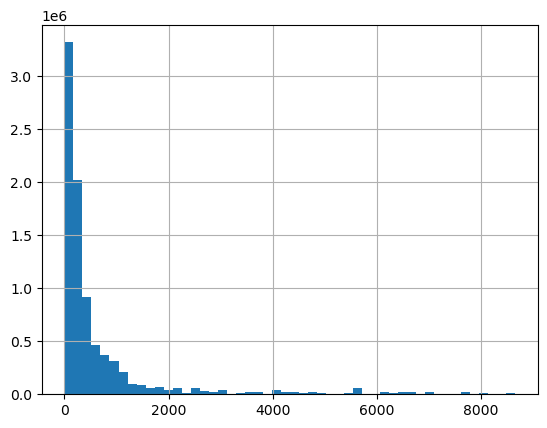

In [54]:
df_merge_3.covid_cases.hist(bins=50)

In [56]:
def fill_with_percentile(
    df: pd.DataFrame, 
    column: str, 
    percentile: float = 0.03,
    logging: bool = True
):
    
    quantile_value = df[column].quantile(percentile)
    
    if logging:
        print(f'Percentile {percentile} value is: ', quantile_value)
        
    df[column] = df[column].fillna(quantile_value)
    
    return df

In [57]:
df_merge_3 = fill_with_percentile(df_merge_3, 'covid_cases')

Percentile 0.03 value is:  6.0


We could add also information about in which dates the people where closed into their homes.

In [58]:
confinment_start = '2020-03-14'
confinment_date_start = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [59]:
confinment_end = '2020-06-21'
confinment_date_end = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [60]:
index_non_confinment = df_merge_3[
    (df_merge_3['date'] < confinment_date_start) |
    (df_merge_3['date'] > confinment_date_end)
].index

In [61]:
df_merge_3.loc[index_non_confinment, 'confinment'] = 0
df_merge_3['confinment'] = df_merge_3['confinment'].fillna(1)
df_merge_3['confinment'] = df_merge_3['confinment'].astype('int')

### Barcelona Events

In [ ]:
os.makedirs('./events', exist_ok=True)

In [ ]:
def get_opendataevents_json(url: str = 'https://www.bcn.cat/tercerlloc/files/opendatabcn_agenda.json'):
    res = requests.get(url)
    return res.json()

In [ ]:
if not os.path.isfile('./events/opendatabcn_agenda.json'):
    events_json = get_opendataevents_json()
    events_df = pd.DataFrame(events_json)
    events_df.to_csv('./events/opendatabcn_agenda.json', index=False, header=True)

else:
    events_df = pd.read_csv('./events/opendatabcn_agenda.json')

In [ ]:
events_df.head()

In [ ]:
# Only having active dates
events_df = events_df[events_df.core_type_name != 'Equipament']
events_df = events_df[events_df.event_status == 'ok']

In [ ]:
#def events_df_drop_columns(
#    events_df: pd.DataFrame, 
#    columns_to_drop: typing.List[str] = [
#        'register_id', 'prefix', 'suffix', 'name', 'created', 'modified', 'status', 'status_name',     # too specific
#        'core_type', 'core_type_name',                                                                 # most is only one type of value
#        'body', 'tickets_data', 'addresses', 'entity_types_data', 'attribute_categories', 'values',
#        'from_relationships', 'to_relationships', 'classifications_data', 'secondary_filters_data',
#        'timetable', 'image_data', 'gallery_data', 'warnings',                                         # unuseful information
#        'is_section_of_data', 'sections_data', 'estimated_dates', 'languages_data', 'type', 'type_name',
#        'period', 'period_name', 'event_status_name', 'event_status', 'ical',
#        'geo_epgs_25831', 'geo_epgs_23031'                                                             # unwanted loations
#    ]
#):
    
#    return events_df.drop(columns_to_drop, axis=1, errors='ignore')

In [ ]:
# Drop columns not wanted
#events_df = events_df_drop_columns(events_df)

In [ ]:
events_df = events_df.drop(['suffix', 'status', 'status_name', 'values', 'from_relationships', 'to_relationships'], axis=1)
#events_df = events_df.drop(df[df['core_type_name'] == 'Equipament'].index)
events_df = events_df.drop(['core_type', 'core_type_name', 
              'body', 'entity_types_data', 
              'attribute_categories', 'classifications_data', 
             'secondary_filters_data', 'timetable', 
             'image_data', 'warnings', 'is_section_of_data', 'sections_data',
             'type_name', 'period', 'gallery_data', 'addresses'], axis=1)
#events_df = events_df.drop(df[df['event_status'] == 'suspended'].index)
#events_df = events_df.drop(df[df['event_status'] == 'deferred'].index)
events_df = events_df.drop(['event_status_name', 'event_status', 'ical', 'estimated_dates'], axis=1)
events_df = events_df.drop(['geo_epgs_25831', 'geo_epgs_23031'], axis=1)


In [ ]:
events_df = events_df.drop(['created', 'modified'], axis=1)
events_df = events_df.drop(events_df[events_df['type'] == 'permanent'].index)
#I am dropping the permanent events because they do not have significant
#impact of the bicing frequency

In [ ]:
# Drop events with not enough data
events_df.dropna(
    axis=0, 
    how='any', 
    subset=['geo_epgs_4326', 'start_date'], 
    inplace=True
)

In [ ]:
events_df.head()

In [ ]:
def get_event_geographics(geo_position: str):
    geo_position = ast.literal_eval(geo_position)
    return geo_position['x'], geo_position['y']

In [ ]:
events_geographic_x_y = events_df.geo_epgs_4326.apply(lambda x: get_event_geographics(x))
events_df['x'] = [x for x, _ in events_geographic_x_y]
events_df['y'] = [y for _, y in events_geographic_x_y]

events_df = events_df[events_df.x > 0]
events_df = events_df[events_df.y > 0]

events_df.drop(['geo_epgs_4326'], axis=1, inplace=True)

In [ ]:
sns.jointplot(x="x", y="y", data= events_df, alpha=0.1)

In [ ]:
# In the case of null values of end date, we will assume is the same as start date (we will consider only days)
events_df.end_date.fillna(events_df.start_date, inplace=True)

In [ ]:
events_df['start_date'] = pd.to_datetime(events_df['start_date'], utc=True).dt.date
events_df['end_date'] = pd.to_datetime(events_df['end_date'], utc=True).dt.date

events_df['year'] = pd.to_datetime(events_df['start_date'], utc=True).dt.year
print(events_df['year'].value_counts())

### Include the dataframe with the holidays

In [62]:
from functools import lru_cache
import ics
import icalendar
from icalendar import Calendar, Event, vCalAddress, vText
from pathlib import Path
import pytz

In [63]:
e = open('calendarifestius_en.ics', 'rb')
ecal = icalendar.Calendar.from_ical(e.read())
for component in ecal.walk():
    print(component.name)
e.close()

VCALENDAR
VTIMEZONE
DAYLIGHT
STANDARD
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT


In [64]:
# Extract relevant information
events = []
for event in ecal.walk('VEVENT'):
    event_data = {
        'Summary': event.get('summary'),
        'Start': event.get('dtstart').dt,
        'End': event.get('dtend').dt,
        # Add more properties as needed
    }
    events.append(event_data)

# Create a DataFrame from the extracted information
df_ecal = pd.DataFrame(events)

# Print the DataFrame
print(df_ecal.dtypes)

Summary    object
Start      object
End        object
dtype: object


In [65]:
df_ecal['Start'] = pd.to_datetime(df_ecal['Start'], utc=True)
df_ecal['End'] = pd.to_datetime(df_ecal['End'], utc=True)
print(df_ecal.dtypes)

Summary                 object
Start      datetime64[ns, UTC]
End        datetime64[ns, UTC]
dtype: object


In [66]:
df_ecal = df_ecal.rename(columns={"Start": 'start_date', "End": 'end_date', "Summary":"name"})


In [67]:
df_ecal['year'] = df_ecal['start_date'].dt.year
df_ecal['month'] = df_ecal['start_date'].dt.month
df_ecal['day'] = df_ecal['start_date'].dt.day

df_ecal['end_day'] = df_ecal['end_date'].dt.day
df_ecal['end_month'] = df_ecal['end_date'].dt.month

In [68]:
#Since these holidays last the whole week, I will remove them and add
#manually christmas and easter holidays
df_ecal = df_ecal.drop(df_ecal[df_ecal['name'] == 'Good Friday'].index)
df_ecal = df_ecal.drop(df_ecal[df_ecal['name'] == 'Easter Monday'].index)
df_ecal = df_ecal.drop(df_ecal[df_ecal['name'] == 'Christmas'].index)
df_ecal = df_ecal.drop(df_ecal[df_ecal['name'] == 'Boxing Day'].index)

In [69]:
def holy_week(df, name, start_date, end_date):
    df = pd.DataFrame({'name': [name], 'start_date': [start_date],
                              'end_date' : [end_date]})
    df['start_date'] = pd.to_datetime(df['start_date'], utc=True)
    df['end_date'] = pd.to_datetime(df['end_date'], utc=True)
    df['day'] = df['start_date'].dt.day
    df['month'] = df['start_date'].dt.month
    df['year'] = df['start_date'].dt.year
    df['end_day'] = df['end_date'].dt.day
    df['end_month'] = df['end_date'].dt.month
    return df
   
holy_week_2023 = holy_week(df, 'Holy Week 2023', "2023-04-02 00:00:00+00:00", "2023-04-10 00:00:00+00:00")
holy_week_2022 = holy_week(df, 'Holy Week 2022', "2022-04-10 00:00:00+00:00", "2022-04-18 00:00:00+00:00")
holy_week_2021 = holy_week(df, 'Holy Week 2021', "2021-03-28 00:00:00+00:00", "2021-04-05 00:00:00+00:00")
holy_week_2020 = holy_week(df, 'Holy Week 2020', "2020-04-05 00:00:00+00:00", "2020-04-13 00:00:00+00:00")
holy_week_2019 = holy_week(df, 'Holy Week 2019', "2019-04-14 00:00:00+00:00", "2019-04-22 00:00:00+00:00")


df_ecal = df_ecal.append(holy_week_2023, ignore_index=True)
df_ecal = df_ecal.append(holy_week_2022, ignore_index=True)
df_ecal = df_ecal.append(holy_week_2021, ignore_index=True)
df_ecal = df_ecal.append(holy_week_2020, ignore_index=True)
df_ecal = df_ecal.append(holy_week_2019, ignore_index=True)
df_ecal.head()

,name,start_date,end_date,year,month,day,end_day,end_month
0,Epiphany / Three Kings’ Day,2023-01-06 00:00:00+00:00,2023-01-07 00:00:00+00:00,2023,1,6,7,1
1,Labour Day,2023-05-01 00:00:00+00:00,2023-05-02 00:00:00+00:00,2023,5,1,2,5
2,Local holidays in Barcelona,2023-06-05 00:00:00+00:00,2023-06-06 00:00:00+00:00,2023,6,5,6,6
3,Sant Joan / Midsummer solstice,2023-06-24 00:00:00+00:00,2023-06-25 00:00:00+00:00,2023,6,24,25,6
4,Assumption of Mary,2023-08-15 00:00:00+00:00,2023-08-16 00:00:00+00:00,2023,8,15,16,8


In [70]:
def xmas_time(df, name, start_date, end_date):
    df = pd.DataFrame({'name': [name], 'start_date': [start_date],
                              'end_date' : [end_date]})
    df['start_date'] = pd.to_datetime(df['start_date'], utc=True)
    df['end_date'] = pd.to_datetime(df['end_date'], utc=True)
    df['day'] = df['start_date'].dt.day
    df['month'] = df['start_date'].dt.month
    df['year'] = df['start_date'].dt.year
    df['end_day'] = df['end_date'].dt.day
    df['end_month'] = df['end_date'].dt.month
    return df
   
xmas_2023 = xmas_time(df, 'Christmas 2023', "2023-12-25 00:00:00+00:00", "2024-01-02 00:00:00+00:00")
xmas_2022 = xmas_time(df, 'Christmas 2022', "2022-12-25 00:00:00+00:00", "2023-01-02 00:00:00+00:00")
xmas_2021 = xmas_time(df, 'Christmas 2021', "2021-12-25 00:00:00+00:00", "2022-01-02 00:00:00+00:00")
xmas_2020 = xmas_time(df, 'Christmas 2020', "2020-12-25 00:00:00+00:00", "2021-01-02 00:00:00+00:00")
xmas_2019 = xmas_time(df, 'Christmas 2019', "2019-12-25 00:00:00+00:00", "2020-01-02 00:00:00+00:00")


df_ecal = df_ecal.append(xmas_2023, ignore_index=True)
df_ecal = df_ecal.append(xmas_2022, ignore_index=True)
df_ecal = df_ecal.append(xmas_2021, ignore_index=True)
df_ecal = df_ecal.append(xmas_2020, ignore_index=True)
df_ecal = df_ecal.append(xmas_2019, ignore_index=True)
df_ecal.head()

,name,start_date,end_date,year,month,day,end_day,end_month
0,Epiphany / Three Kings’ Day,2023-01-06 00:00:00+00:00,2023-01-07 00:00:00+00:00,2023,1,6,7,1
1,Labour Day,2023-05-01 00:00:00+00:00,2023-05-02 00:00:00+00:00,2023,5,1,2,5
2,Local holidays in Barcelona,2023-06-05 00:00:00+00:00,2023-06-06 00:00:00+00:00,2023,6,5,6,6
3,Sant Joan / Midsummer solstice,2023-06-24 00:00:00+00:00,2023-06-25 00:00:00+00:00,2023,6,24,25,6
4,Assumption of Mary,2023-08-15 00:00:00+00:00,2023-08-16 00:00:00+00:00,2023,8,15,16,8


In [71]:
print(df_ecal.shape)

# Define a function to duplicate rows based on the days between 'starting_date' and 'ending_date'
def duplicate_rows(row):
    date_range = pd.date_range(start=row['start_date'], end=row['end_date'], closed='left')
    duplicated_rows = pd.DataFrame({'start_date': date_range[1:]}, index=range(1, len(date_range)))
    return duplicated_rows

# Apply the function to each row and concatenate the results
duplicated_df = pd.concat(df_ecal.apply(duplicate_rows, axis=1).tolist())
duplicated_df['day'] = duplicated_df['start_date'].dt.day
duplicated_df['month'] = duplicated_df['start_date'].dt.month
duplicated_df['year'] = duplicated_df['start_date'].dt.year
# Merge duplicated rows with the original DataFrame
df_ecal = pd.concat([df_ecal, duplicated_df], ignore_index=True)

print(df_ecal.shape)

(21, 8)
(91, 8)


In [72]:
# Define the condition
condition = (df_ecal['year'] == 2023) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition, 'name'] = 'Holy week 2023'

# Define the condition
condition_22 = (df_ecal['year'] == 2022) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_22, 'name'] = 'Holy week 2022'

# Define the condition
condition_21 = (df_ecal['year'] == 2021) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_21, 'name'] = 'Holy week 2021'

# Define the condition
condition_21 = (df_ecal['year'] == 2021) & (df_ecal['month'] == 3)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_21, 'name'] = 'Holy week 2021'

# Define the condition
condition_20 = (df_ecal['year'] == 2020) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_20, 'name'] = 'Holy week 2020'

# Define the condition
condition_19 = (df_ecal['year'] == 2019) & (df_ecal['month'] == 4)
# Modify the values of column 'c' where the condition is True
df_ecal.loc[condition_19, 'name'] = 'Holy week 2019'

print(df_ecal.shape)

(91, 8)


In [73]:
df_ecal = df_ecal.sort_index(axis=0)
df_ecal

,name,start_date,end_date,year,month,day,end_day,end_month
0,Epiphany / Three Kings’ Day,2023-01-06 00:00:00+00:00,2023-01-07 00:00:00+00:00,2023,1,6,7.0,1.0
1,Labour Day,2023-05-01 00:00:00+00:00,2023-05-02 00:00:00+00:00,2023,5,1,2.0,5.0
2,Local holidays in Barcelona,2023-06-05 00:00:00+00:00,2023-06-06 00:00:00+00:00,2023,6,5,6.0,6.0
3,Sant Joan / Midsummer solstice,2023-06-24 00:00:00+00:00,2023-06-25 00:00:00+00:00,2023,6,24,25.0,6.0
4,Assumption of Mary,2023-08-15 00:00:00+00:00,2023-08-16 00:00:00+00:00,2023,8,15,16.0,8.0
...,...,...,...,...,...,...,...,...
86,NaN,2019-12-28 00:00:00+00:00,NaT,2019,12,28,NaN,NaN
87,NaN,2019-12-29 00:00:00+00:00,NaT,2019,12,29,NaN,NaN
88,NaN,2019-12-30 00:00:00+00:00,NaT,2019,12,30,NaN,NaN
89,NaN,2019-12-31 00:00:00+00:00,NaT,2019,12,31,NaN,NaN


In [74]:
# XMAS 2023-2024
condition = (df_ecal['year'] == 2023) & (df_ecal['month'] == 12)
df_ecal.loc[condition, 'name'] = 'Christmas 2023'

condition = (df_ecal['year'] == 2024) & (df_ecal['month'] == 1)
df_ecal.loc[condition, 'name'] = 'Christmas 2023'

# XMAS 2022-2023
condition_22 = (df_ecal['year'] == 2022) & (df_ecal['month'] == 12)
df_ecal.loc[condition_22, 'name'] = 'Christmas 2022'

condition_22 = (df_ecal['year'] == 2023) & (df_ecal['month'] == 1)
df_ecal.loc[condition_22, 'name'] = 'Christmas 2022'

# XMAS 2021-2022
condition_21 = (df_ecal['year'] == 2021) & (df_ecal['month'] == 12)
df_ecal.loc[condition_21, 'name'] = 'Christmas 2021'

condition_21 = (df_ecal['year'] == 2022) & (df_ecal['month'] == 1)
df_ecal.loc[condition_21, 'name'] = 'Christmas 2021'

# XMAS 2020-2021
condition_20 = (df_ecal['year'] == 2020) & (df_ecal['month'] == 12)
df_ecal.loc[condition_20, 'name'] = 'Christmas 2020'

condition_20 = (df_ecal['year'] == 2021) & (df_ecal['month'] == 1)
df_ecal.loc[condition_20, 'name'] = 'Christmas 2020'

# XMAS 2019-2020
condition_19 = (df_ecal['year'] == 2019) & (df_ecal['month'] == 12)
df_ecal.loc[condition_19, 'name'] = 'Christmas 2019'

condition_19 = (df_ecal['year'] == 2020) & (df_ecal['month'] == 1)
df_ecal.loc[condition_19, 'name'] = 'Christmas 2019'

In [75]:
df_ecal.head()

,name,start_date,end_date,year,month,day,end_day,end_month
0,Christmas 2022,2023-01-06 00:00:00+00:00,2023-01-07 00:00:00+00:00,2023,1,6,7.0,1.0
1,Labour Day,2023-05-01 00:00:00+00:00,2023-05-02 00:00:00+00:00,2023,5,1,2.0,5.0
2,Local holidays in Barcelona,2023-06-05 00:00:00+00:00,2023-06-06 00:00:00+00:00,2023,6,5,6.0,6.0
3,Sant Joan / Midsummer solstice,2023-06-24 00:00:00+00:00,2023-06-25 00:00:00+00:00,2023,6,24,25.0,6.0
4,Assumption of Mary,2023-08-15 00:00:00+00:00,2023-08-16 00:00:00+00:00,2023,8,15,16.0,8.0


In [76]:
# Define the condition to drop rows prior to a specific datetime
condition_1 = df_ecal['start_date'] < pd.to_datetime('2019-03-28 00:00:00+00:00', utc=True)
print(df_ecal.shape)
condition_2 = df_ecal['start_date'] > pd.to_datetime('2023-04-30 00:00:00+00:00', utc=True)
# Drop the rows that satisfy the condition
df_ecal = df_ecal.drop(df_ecal[condition_1].index)
df_ecal = df_ecal.drop(df_ecal[condition_2].index)
print(df_ecal.shape)

(91, 8)
(73, 8)


In [77]:
df_ecal = df_ecal.drop(['end_date', 'end_day', 'end_month'], axis=1)

## Append df events_df together with the df_ecal, although it is probably unneccessary.

In [ ]:
df_append = events_df.append(df_ecal, ignore_index=True)

In [ ]:
#For the moment I am going to drop the tickets and the language,
#unless we found a way to be related
df_append = df_append.drop(['tickets_data', 'languages_data'], axis=1)

In [ ]:
df_append['period_name'] = df_append['period_name'].fillna(0)
df_append['period_name'] = np.where(df_append['period_name'] == 0, 'anual', df_append['period_name'])

df_append['type'] = df_append['type'].fillna(0)
df_append['type'] = np.where(df_append['type'] == 0, 'repetitive', df_append['type'])

df_append['prefix'] = df_append['prefix'].fillna(0)
df_append['prefix'] = np.where(df_append['prefix'] == 0, 'Local holiday', df_append['prefix'])


In [ ]:
# Define the condition
condition_holy_week = df_append['name'].str.startswith('Holy') == True

# Modify the values of column 'c' where the condition is True
df_append.loc[condition_holy_week, 'type'] = 'unique'

In [ ]:
# Define the condition
condition_xmas = df_append['name'].str.startswith('Christmas') == True

# Modify the values of column 'c' where the condition is True
df_append.loc[condition_xmas, 'type'] = 'unique'

In [ ]:
# Define the condition to drop rows prior to a specific datetime
condition_1 = df_append['start_date'] < pd.to_datetime('2019-03-28 00:00:00+00:00', utc=True)
print(df_append.shape)
condition_2 = df_append['start_date'] > pd.to_datetime('2023-04-30 00:00:00+00:00', utc=True)
# Drop the rows that satisfy the condition
df_append = df_append.drop(df_append[condition_1].index)
df_append = df_append.drop(df_append[condition_2].index)
print(df_append.shape)

In [ ]:
# Filter out by maximum and minimum dates of df
#df_min_date, df_max_date = df.date.min(), df.date.max()

#events_df = events_df[events_df.start_date > df_min_date]
#events_df = events_df[events_df.end_date < df_max_date]

In [ ]:
print(df_append.shape)
df_append.head()

## These are the data sets that we have:
events_df --> the events happening in Barcelona, with specific location
df_ecal --> calendar with the local holidays in Barcelona
df_append --> append of the two previous dataframes. I don't think we need it

In [ ]:
std_dev_x, std_dev_y = events_df.x.std(), events_df.y.std()

In [ ]:
# Filter df by the dates that we have
df_common_events = pd.concat(
    [
        pd.merge(df, events_df, left_on='date', right_on='start_date'), 
        pd.merge(df, events_df, left_on='date', right_on='end_date')
    ],
    axis=0
).drop_duplicates()

In [ ]:
print(df_common_events.shape)

print(df_common_events['year_x'].value_counts())

In [ ]:
with tqdm(total=len(events_df)) as pbar:
    for idx, row in events_df.iterrows():    
        # Filter by the range of the dates
        x, y = row.x, row.y
        start_date, end_date = row['start_date'], row['end_date']
        range_dates = pd.date_range(start_date, end_date)
        range_df = df_common_events[df_common_events.date.isin(range_dates)]
        
        if len(range_df) > 0:
            # Near position of the event with relation of the biking center (30% of standard deviations of x & y)
            range_df = range_df[(range_df.lat > x - std_dev_x * 0.3) & (range_df.lat < x + std_dev_x * 0.3)]
            range_df = range_df[(range_df.lat > y - std_dev_y * 0.3) & (range_df.lat < y + std_dev_y * 0.3)]
            df.loc[range_df.index, 'has_event'] = 1

        pbar.update(1)
    

In [ ]:
df.has_event = df.has_event.fillna(0)

In [ ]:
df.head()

In [ ]:
df['year'].value_counts()

In [ ]:
df.columns.values

# Come back to df_ecal data set. Lastest modifications before merging to the main data set

In [78]:
df_ecal = df_ecal.rename(columns={"start_date": 'date_time'})
df_ecal['has_holidays'] = df_ecal['name']
df_ecal['has_holidays'] = 1

df_ecal['date'] = pd.to_datetime(df_ecal['date_time']).dt.date


In [79]:
print(df_ecal['date_time'].dtype)
print(df['date_time'].dtype)

datetime64[ns, UTC]
datetime64[ns]


In [80]:
df_ecal['date_time'] = pd.to_datetime(df_ecal.date_time).dt.tz_localize(None)
df_ecal['date_time'] = df_ecal['date_time'].astype('object')

Merge main dataset with df_ecal 

In [81]:
print(df_merge_3.shape)
df_merge_4 = pd.merge(df_merge_3, df_ecal, on=['year', 'month', 'day', 'date'], how='left')
print(df_merge_4.shape)


(16668022, 56)
(16668022, 59)


In [71]:
df_merge['year'].value_counts()

2021    194138
2022    193978
2019    144063
2020     94537
2023     77917
Name: year, dtype: int64

In [72]:
df_merge.has_holidays = df_merge.has_holidays.fillna(0)

Once we have extended our dataframe with external sources, we are going to make the selection of the columns that we want.

In [74]:
selected_columns_df = [
    'station_id', 
    'num_bikes_available', 'num_bikes_available_types.mechanical',                            # docks info
    'num_bikes_available_types.ebike', 'num_docks_available', 'percentage_docks_available',   # docks info
    'status', 'lat', 'lon', 'altitude', 'capacity',                                           # station info
    'year', 'month', 'day', 'hour', 'date_time_x', 'date_time_y', 'date',                                      # time info
    'traffic', 'covid_cases', 'confinment', 'has_holidays',                                     # context info
    'temp', 'feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'uvindex', 'visibility',  # meteorological info
]

selected_df = df_merge[selected_columns_df]

In [77]:
# Checkpoint of the extended df with external sources
selected_df.to_csv(
    'df_selected.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

In [5]:
#file = pd.read_csv('df_selected.csv')
#selected_df = pd.DataFrame(file)
#selected_df['year'].value_counts()
#print(selected_df.shape)

(704633, 30)


In [4]:
import gzip
selected_df = pd.read_csv('df_selected.csv.gz', compression='gzip', 
                            header=0, sep=',', quotechar='"')

In [5]:
selected_df.shape

(704633, 30)

## Data Engineering

Engineer new variables from the information that we already have. 

In [6]:
selected_df.date_time_x = pd.to_datetime(selected_df.date_time_x)

### Time

In [7]:
# Would need to get the dummies for them
date_time_fields = ['day_info', 'hour_info', 'month_info']

Related to the **day** (weekend).

In [8]:
def get_day_info(date_time_x):
    return 'weekend' if date_time_x.weekday() in [5, 6] else 'weekday'

In [9]:
selected_df['day_info'] = selected_df.date_time_x.apply(lambda x: get_day_info(x))

Related to the **hour** (which time of day it was).

In [10]:
def get_hour_info(date_time):
    if date_time.hour in range(5):
        return 'late_night'

    elif date_time.hour in range(5, 9):
        return 'early_morning'

    elif date_time.hour in range(9, 13):
        return 'morning'
    
    elif date_time.hour in range(13, 17):
        return 'noon'
    
    elif date_time.hour in range(17, 21):
        return 'eve'
    
    return 'night'

In [11]:
selected_df['hour_info'] = selected_df.date_time_x.apply(lambda x: get_hour_info(x))

Related to the **month** (season).

In [12]:
def get_month_info(date):
    if date.month in (3, 4, 5):
        return 'spring'
    
    elif date.month in (6, 7, 8):
        return 'summer'
    
    elif date.month in (9, 10, 11):
        return 'autumn'
    
    return 'winter'

In [13]:
selected_df['month_info'] = selected_df.date_time_x.apply(lambda x: get_month_info(x))

In [14]:
selected_df.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,percentage_docks_available,status,lat,lon,altitude,capacity,year,month,day,hour,date_time_x,date_time_y,date,traffic,covid_cases,confinment,has_holidays,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,day_info,hour_info,month_info
0,1,37.500000,34.916667,2.583333,8.416667,4.455446,1.0,41.397978,2.180107,16.0,46,2023,1,1,0,2023-01-01 00:00:00,2023-01-01 00:00:00,2023-01-01,0.0,6.0,0,1,10.6,9.8,81.4,0.0,0.0,12.5,3.0,14.3,weekend,late_night,winter
1,1,39.333333,36.666667,2.666667,6.666667,5.900000,1.0,41.397978,2.180107,16.0,46,2023,1,1,1,2023-01-01 01:00:00,2023-01-01 00:00:00,2023-01-01,0.0,6.0,0,1,10.6,9.8,81.4,0.0,0.0,12.5,3.0,14.3,weekend,late_night,winter
2,1,38.666667,37.416667,1.250000,7.250000,5.333333,1.0,41.397978,2.180107,16.0,46,2023,1,1,2,2023-01-01 02:00:00,2023-01-01 00:00:00,2023-01-01,0.0,6.0,0,1,10.6,9.8,81.4,0.0,0.0,12.5,3.0,14.3,weekend,late_night,winter
3,1,39.583333,37.833333,1.750000,6.250000,6.333333,1.0,41.397978,2.180107,16.0,46,2023,1,1,3,2023-01-01 03:00:00,2023-01-01 00:00:00,2023-01-01,0.0,6.0,0,1,10.6,9.8,81.4,0.0,0.0,12.5,3.0,14.3,weekend,late_night,winter
4,1,39.333333,38.250000,1.083333,6.583333,5.974684,1.0,41.397978,2.180107,16.0,46,2023,1,1,4,2023-01-01 04:00:00,2023-01-01 00:00:00,2023-01-01,0.0,6.0,0,1,10.6,9.8,81.4,0.0,0.0,12.5,3.0,14.3,weekend,late_night,winter


### Data Shifting

We need to create a shift of the availability in the previous availabilities.

In [15]:
selected_df = selected_df.sort_values(['station_id', 'date_time_x'], ascending=True)

In [16]:
df_shifted = pd.DataFrame()

In [17]:
for station_id in tqdm(selected_df.station_id.unique()):
    station_df = selected_df[selected_df.station_id == station_id]
    station_df['ctx-4'] = station_df.percentage_docks_available.shift(4)
    station_df['ctx-3'] = station_df.percentage_docks_available.shift(3)
    station_df['ctx-2'] = station_df.percentage_docks_available.shift(2)
    station_df['ctx-1'] = station_df.percentage_docks_available.shift(1)
    
    df_shifted = pd.concat([station_df, df_shifted], axis=0)

100%|█████████████████████████████████████████| 509/509 [01:04<00:00,  7.87it/s]


In [18]:
df_shifted.shape

(704633, 37)

### Train / Val / Test Split

In [19]:
#For plotting the variables
selected_columns_df = [
    'station_id', 
    'num_bikes_available', 'num_bikes_available_types.mechanical',                            # docks info
    'num_bikes_available_types.ebike', 'num_docks_available', 'percentage_docks_available',   # docks info
    'status', 'lat', 'lon', 'altitude', 'capacity',                                           # station info
    'year', 'month', 'day', 'hour', 'traffic', 'covid_cases', 'confinment', 'has_holidays',                                     # context info
    'temp', 'feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'uvindex', 'visibility', # meteorological info
    'day_info', 'hour_info', 'month_info', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4']


In [20]:
df_shifted.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,percentage_docks_available,status,lat,lon,altitude,capacity,year,month,day,hour,date_time_x,date_time_y,date,traffic,covid_cases,confinment,has_holidays,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,day_info,hour_info,month_info,ctx-4,ctx-3,ctx-2,ctx-1
487705,519,6.833333,0.0,6.833333,17.166667,0.398058,1.0,41.424655,2.166289,110.0,24,2020,12,25,0,2020-12-25 00:00:00,2020-12-25 00:00:00,2020-12-25,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,weekday,late_night,winter,NaN,NaN,NaN,NaN
487706,519,7.500000,0.0,7.500000,16.500000,0.454545,1.0,41.424655,2.166289,110.0,24,2020,12,25,1,2020-12-25 01:00:00,2020-12-25 00:00:00,2020-12-25,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,weekday,late_night,winter,NaN,NaN,NaN,0.398058
487707,519,8.000000,0.0,8.000000,16.000000,0.500000,1.0,41.424655,2.166289,110.0,24,2020,12,25,2,2020-12-25 02:00:00,2020-12-25 00:00:00,2020-12-25,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,weekday,late_night,winter,NaN,NaN,0.398058,0.454545
487708,519,8.000000,0.0,8.000000,16.000000,0.500000,1.0,41.424655,2.166289,110.0,24,2020,12,25,3,2020-12-25 03:00:00,2020-12-25 00:00:00,2020-12-25,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,weekday,late_night,winter,NaN,0.398058,0.454545,0.500000
487709,519,7.818182,0.0,7.818182,16.181818,0.483146,1.0,41.424655,2.166289,110.0,24,2020,12,25,4,2020-12-25 04:00:00,2020-12-25 00:00:00,2020-12-25,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,weekday,late_night,winter,0.398058,0.454545,0.500000,0.500000


In [21]:
df_shifted = df_shifted[selected_columns_df]

In [22]:
train_df = df_shifted[df_shifted.year != 2023]
test_df = df_shifted[df_shifted.year == 2023]

In [23]:
print('Train size: ', train_df.shape)
print('Test size: ', test_df.shape)

Train size:  (626716, 34)
Test size:  (77917, 34)


### Exploration

In [24]:
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn import model_selection
from sklearn import neighbors

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Cleaning train_df dataset

In [25]:
#Get dummies from categorical values (One-Hot encoder)
def get_dummies(df, column_name):
    type_feature = df[column_name]
    type_dummies = pd.get_dummies(type_feature, prefix=column_name)
    df = pd.concat([df, type_dummies], axis=1).drop(columns=[column_name])
    return df

train_df = get_dummies(train_df, 'day_info')
train_df = get_dummies(train_df, 'month_info')
train_df = get_dummies(train_df, 'hour_info')

In [26]:
train_df['covid_cases'] = train_df['covid_cases'].fillna(0)

In [27]:
train_df['percentage_docks_available'] = train_df['percentage_docks_available'].fillna(0)

In [28]:
train_df['ctx-4'] = train_df['ctx-4'].fillna(0)
train_df['ctx-3'] = train_df['ctx-3'].fillna(0)
train_df['ctx-2'] = train_df['ctx-2'].fillna(0)
train_df['ctx-1'] = train_df['ctx-1'].fillna(0)

In [30]:
def infinite_values(df):
    count = np.isinf(df).values.sum()
    print("It contains " + str(count) + " infinite values")
    print("printing column name where infinity is present")
    col_name = df.columns.to_series()[np.isinf(df).any()]
    print(col_name)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    count = np.isinf(df).values.sum()
    print("After replacing inifite values, now it contains " + str(count) + " infinite values")
    return df

train_df = infinite_values(train_df)

It contains 0 infinite values
printing column name where infinity is present
Series([], dtype: object)
After replacing inifite values, now it contains 0 infinite values


In [35]:
train_df

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,percentage_docks_available,status,lat,lon,altitude,capacity,year,month,day,hour,traffic,covid_cases,confinment,has_holidays,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,ctx-1,ctx-2,ctx-3,ctx-4,day_info_weekday,day_info_weekend,month_info_spring,month_info_winter,hour_info_early_morning,hour_info_eve,hour_info_late_night,hour_info_morning,hour_info_night,hour_info_noon
487705,519,6.833333,0.000000,6.833333,17.166667,0.398058,1.0,41.424655,2.166289,110.0,24,2020,12,25,0,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,0.000000,0.000000,0.000000,0.000000,1,0,0,1,0,0,1,0,0,0
487706,519,7.500000,0.000000,7.500000,16.500000,0.454545,1.0,41.424655,2.166289,110.0,24,2020,12,25,1,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,0.398058,0.000000,0.000000,0.000000,1,0,0,1,0,0,1,0,0,0
487707,519,8.000000,0.000000,8.000000,16.000000,0.500000,1.0,41.424655,2.166289,110.0,24,2020,12,25,2,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,0.454545,0.398058,0.000000,0.000000,1,0,0,1,0,0,1,0,0,0
487708,519,8.000000,0.000000,8.000000,16.000000,0.500000,1.0,41.424655,2.166289,110.0,24,2020,12,25,3,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,0.500000,0.454545,0.398058,0.000000,1,0,0,1,0,0,1,0,0,0
487709,519,7.818182,0.000000,7.818182,16.181818,0.483146,1.0,41.424655,2.166289,110.0,24,2020,12,25,4,0.0,171.0,0,1,9.0,7.2,50.0,0.0,0.0,28.6,3.0,18.3,0.500000,0.500000,0.454545,0.398058,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259821,1,34.166667,26.750000,7.416667,11.833333,2.887324,1.0,41.397978,2.180107,16.0,46,2022,12,31,19,0.0,6.0,0,1,14.4,14.4,69.4,0.0,0.0,15.6,4.0,15.8,1.936170,1.196000,1.144531,0.964286,0,1,0,1,0,1,0,0,0,0
259822,1,40.500000,33.416667,7.083333,5.500000,7.363636,1.0,41.397978,2.180107,16.0,46,2022,12,31,20,0.0,6.0,0,1,14.4,14.4,69.4,0.0,0.0,15.6,4.0,15.8,2.887324,1.936170,1.196000,1.144531,0,1,0,1,0,1,0,0,0,0
259823,1,41.000000,35.750000,5.250000,5.000000,8.200000,1.0,41.397978,2.180107,16.0,46,2022,12,31,21,0.0,6.0,0,1,14.4,14.4,69.4,0.0,0.0,15.6,4.0,15.8,7.363636,2.887324,1.936170,1.196000,0,1,0,1,0,0,0,0,1,0
259824,1,40.583333,35.500000,5.083333,5.416667,7.492308,1.0,41.397978,2.180107,16.0,46,2022,12,31,22,0.0,6.0,0,1,14.4,14.4,69.4,0.0,0.0,15.6,4.0,15.8,8.200000,7.363636,2.887324,1.936170,0,1,0,1,0,0,0,0,1,0


# Cleaning test_df dataset

In [31]:
test_df = get_dummies(test_df, 'day_info')
test_df = get_dummies(test_df, 'month_info')
test_df = get_dummies(test_df, 'hour_info')

In [32]:
test_df['covid_cases'] = test_df['covid_cases'].fillna(0)

In [33]:
test_df['ctx-4'] = test_df['ctx-4'].fillna(0)
test_df['ctx-3'] = test_df['ctx-3'].fillna(0)
test_df['ctx-2'] = test_df['ctx-2'].fillna(0)
test_df['ctx-1'] = test_df['ctx-1'].fillna(0)

In [34]:
test_df = infinite_values(test_df)

It contains 999 infinite values
printing column name where infinity is present
percentage_docks_available    percentage_docks_available
ctx-1                                              ctx-1
ctx-2                                              ctx-2
ctx-3                                              ctx-3
ctx-4                                              ctx-4
dtype: object
After replacing inifite values, now it contains 0 infinite values


# Plotting variables

(0.0, 1000.0)

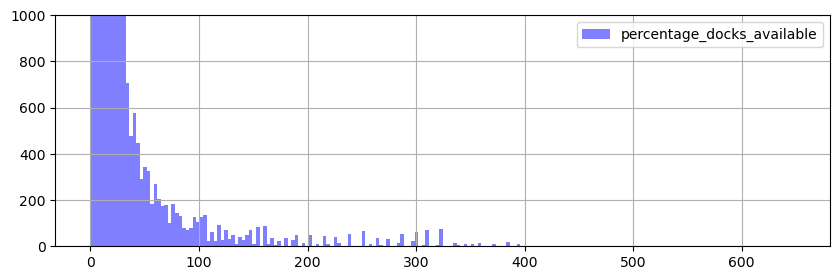

In [51]:
ax = train_df['percentage_docks_available'].hist(bins=200, color='blue', alpha=0.5, figsize=(10,3), legend=True)
ax.set_ylim(0, 1000)

In [52]:
train_df['percentage_docks_available'] = train_df['num_docks_available'] / (train_df['num_docks_available'] + train_df['num_bikes_available'])

(0.0, 10000.0)

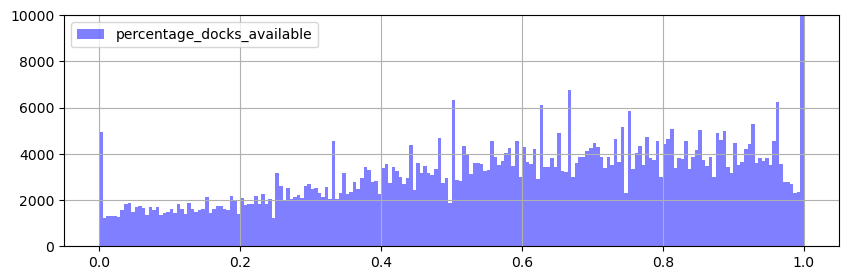

In [54]:
ax = train_df['percentage_docks_available'].hist(bins=200, color='blue', alpha=0.5, figsize=(10,3), legend=True)
ax.set_ylim(0, 10000)

<AxesSubplot:xlabel='hour', ylabel='percentage_docks_available'>

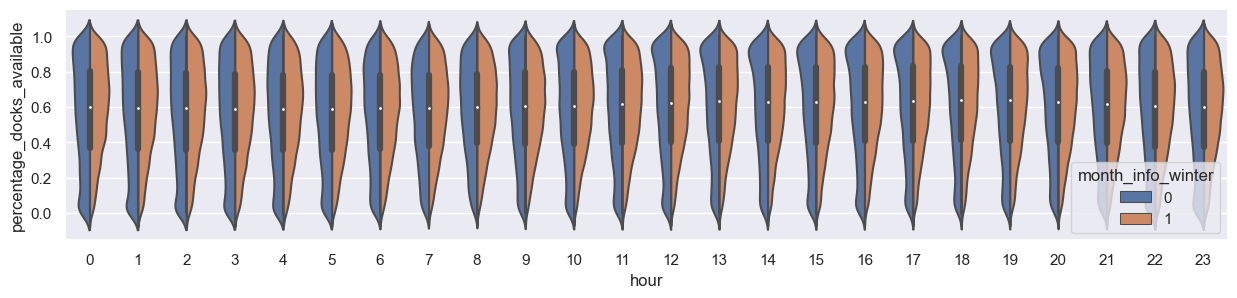

In [69]:
sns.set(rc={'figure.figsize':(15,3)})
sns.violinplot(data=train_df, x="hour", y="percentage_docks_available", hue="month_info_winter", split=True)


In [76]:
sns.set(rc={'figure.figsize':(15,3)})
sns.violinplot(data=train_df, x="hour", y="percentage_docks_available", hue="confinment", split=True)

ValueError: There must be exactly two hue levels to use `split`.'

<AxesSubplot:xlabel='covid_cases', ylabel='percentage_docks_available'>

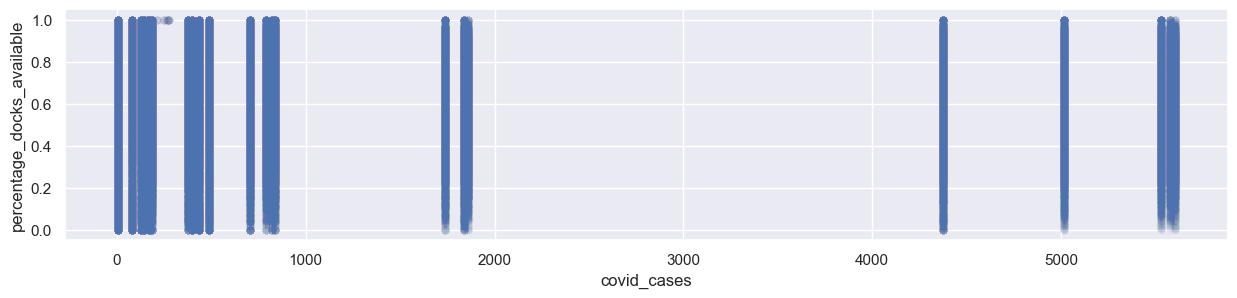

In [73]:
sns.set(rc={'figure.figsize':(15,3)})
sns.scatterplot(data=train_df, x="covid_cases", y="percentage_docks_available", alpha=0.01)

# Prepare data train and validation, and in X and Y

In [218]:
valid_df = test_df[test_df.month <= 3]
test_df = test_df[test_df.month > 3]

In [219]:
print('Validation size: ', valid_df.shape[0])
print('Test size: ', test_df.shape[0])

Validation size:  24003
Test size:  53914


In [229]:
X_train = train_df.copy()
X_train = X_train.drop(["percentage_docks_available"], axis=1)
y_train = train_df["percentage_docks_available"].copy()
print(X_train.shape, y_train.shape)
X_val = valid_df.copy()
X_val = X_val.drop(["percentage_docks_available"], axis=1)
y_val = valid_df["percentage_docks_available"].copy()
print(X_val.shape, y_val.shape)

(626716, 40) (626716,)
(24003, 40) (24003,)


In [230]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train) # Create the transformer StandardScaler and perform the fitting for the training data

X_train_norm = scalerX.transform(X_train)
X_val_norm = scalerX.transform(X_val)

print("\nBefore transformation:")
print('Train: Max {}, min {}, mean {}, and var {}'.format(np.max(X_train), np.min(X_train), np.mean(X_train), np.var(X_train)))
print('Test: Max {}, min {}, mean {}, and var {}'.format(np.max(X_val), np.min(X_val), np.mean(X_val), np.var(X_val)))

print("\nAfter transformation:")
print('Train: Max {}, min {}, mean {}, and var {}'.format(np.max(X_train_norm), np.min(X_train_norm), np.mean(X_train_norm), np.var(X_train_norm)))
print('Test: Max {}, min {}, mean {}, and var {}'.format(np.max(X_val_norm), np.min(X_val_norm), np.mean(X_val_norm), np.var(X_val_norm)))



Before transformation:
Train: Max station_id                               519.000000
num_bikes_available                       54.000000
num_bikes_available_types.mechanical      52.250000
num_bikes_available_types.ebike           33.916667
num_docks_available                       54.000000
status                                     1.000000
lat                                       41.462095
lon                                        2.220691
altitude                                 166.000000
capacity                                  54.000000
year                                    2022.000000
month                                     12.000000
day                                       31.000000
hour                                      23.000000
traffic                                    0.000000
covid_cases                             5604.000000
confinment                                 0.000000
has_holidays                               1.000000
temp                         

### LOGISTIC REGRESSION

In [ ]:
#Fit with linear_model: Logistic Regression
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
'''
Warning The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:
‘lbfgs’ - [‘l2’, None]

‘liblinear’ - [‘l1’, ‘l2’]

‘newton-cg’ - [‘l2’, None]

‘newton-cholesky’ - [‘l2’, None]

‘sag’ - [‘l2’, None]

‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]

Warning: The logistic reggression only gives categorical values, either 0 or 1, but not in between.
'''
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y_train)


logreg = LogisticRegression(solver = 'saga')
logreg.fit(X_train_norm, y_transformed)

#print(logreg.coef_, logreg.intercept_)
losspred = logreg.predict(X_val_norm)


print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",mean_squared_error(y_val, losspred, squared=False))  # This is the competition's metric
print("R^2: ",r2_score(y_val, losspred))

# Using this lines of code we can see the predicted price vs the real price
plt.scatter(y_val, losspred, c='C0', alpha=0.3)
plt.axline((0,0),(1,1), c='C1')
plt.xlabel('Price')
plt.ylabel('Predicted price');
plt.show()


[11712 12953 13878 ... 36134 35864 34715]


CONFUSION MATRIX OF THE LOGISTIC REGRESSION

In [ ]:
cm = metrics.confusion_matrix(y_val, losspred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### K-NEIGHBORS CLASSIFIER WITH CROSS VALIDATION

In [ ]:
k_values = [i for i in range (1,101)]
knn_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_norm, y_train, cv=5)
    knn_scores.append(np.mean(score))
    
sns.lineplot(x = 'k_values', y = 'knn_scores', marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [ ]:
#We now train our model with the best k values
best_index = np.argmax(knn_scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_norm, y_train)

In [ ]:
y_pred = knn.predict(X_val_norm)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

In [ ]:
print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",mean_squared_error(y_val, y_pred, squared=False))  # This is the competition's metric
print("R^2: ",r2_score(y_val, y_pred))

# Using this lines of code we can see the predicted price vs the real price
plt.scatter(y_val, y_pred, c='C0', alpha=0.3)
plt.axline((0,0),(1,1), c='C1')
plt.xlabel('Price')
plt.ylabel('Predicted price');
plt.show()

### DEEP LEARNING, FULLY-CONNECTED NEURAL NETWORK

In [ ]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, Adam
model = Sequential()

In [ ]:
#Set the real number of variables of our final df in input_shape
model.add(Dense(12, input_shape=(8,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train_norm, y_train, epochs=150, batch_size=10)
_, accuracy = model.evaluate(X, y, verbose=0)

In [ ]:
# make probability predictions with the model
y_pred_FCNN = model.predict(X_val_norm)

### SUBMISSION DATA SET

In [ ]:
# First, and very important step, we need to preprocess the test data the same way we have done with the train set. 
X_test = test_set[features].fillna(0)

# Now we can predict the prices for the test set
y_test_pred = model.predict(X_test)

# We generate the submission like this:
df_output = pd.DataFrame(y_test_pred)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']

df_output.to_csv('sample_submission.csv',index=False)
